In [1]:
import sys
sys.path.insert(0, '../src/')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy.sparse as sp
from scipy.sparse import load_npz
import pickle

import torch

import pandas as pd

import networkx as nx

import utils
import evaluation
from net import start_experiments
import graph_statistics
from evaluation import (Evaluation, tabular_from_statistics, df_from_tabular, compute_original_statistics,
                        boxplot)

In [2]:
train_graph, xs = pickle.load(open('../data/datasets/cycle.p', 'rb'))
train_graph = sp.csr_matrix(train_graph)

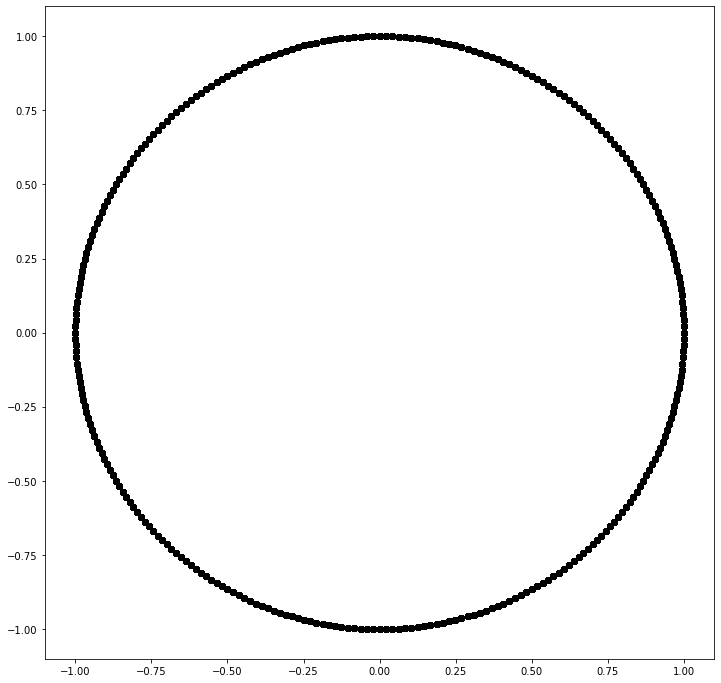

In [3]:
utils.plot_graph(train_graph, xs)

# Train
## Define new loss function that punishes long non-edges

In [4]:
G = nx.from_scipy_sparse_matrix(train_graph)
B = nx.all_pairs_shortest_path_length(G)

B_dict = dict(B)

SP = np.zeros(train_graph.shape)

for start in B_dict.keys():
    for target in B_dict[start].keys():
        SP[start, target] = B_dict[start][target]

In [5]:
def get_my_loss_fn(SP, lam, SP_limit=None):
    SP = torch.tensor(SP)
    if SP_limit:
        SP = lam * (SP <= SP_limit)
    else:
        SP.fill_diagonal_(1)
    def my_loss_fn(W, A, num_edges):
        d = torch.log(torch.exp(W).sum(dim=-1, keepdims=True))
        not_A = 1 - A
        not_A.fill_diagonal_(0)
        
        if SP_limit:
            loss = torch.sum((A + SP) * (d - W))
        else:
            loss = torch.sum((A + lam * (1 / torch.exp(SP))) * (d - W))
        
        
        loss *= .5 / num_edges
        return loss
    return my_loss_fn

## Plain Setting

In [56]:
my_loss_fn = get_my_loss_fn(SP=SP, lam=0, SP_limit=None)
models = start_experiments(num_experiments=5,
                           experiment_root='../logs/cycle/Ours_plain',
                           train_graph=train_graph,
                           H=3,
                           optimizer=torch.optim.Adam,
                           optimizer_args={'lr': 0.1,
                                           'weight_decay': 1e-7},
                           invoke_every=5,
                           steps = 100,
                           loss_fn=my_loss_fn,
                           val_edges=(None, None))


Experiment_0
Step:   5/100, Loss: 5.51053, Edge-Overlap: 0.034
Step:  10/100, Loss: 4.82245, Edge-Overlap: 0.094
Step:  15/100, Loss: 4.27062, Edge-Overlap: 0.155
Step:  20/100, Loss: 3.95784, Edge-Overlap: 0.212
Step:  25/100, Loss: 3.71389, Edge-Overlap: 0.268
Step:  30/100, Loss: 3.52019, Edge-Overlap: 0.335
Step:  35/100, Loss: 3.38221, Edge-Overlap: 0.376
Step:  40/100, Loss: 3.28125, Edge-Overlap: 0.394
Step:  45/100, Loss: 3.20258, Edge-Overlap: 0.457
Step:  50/100, Loss: 3.14218, Edge-Overlap: 0.475
Step:  55/100, Loss: 3.09721, Edge-Overlap: 0.495
Step:  60/100, Loss: 3.06352, Edge-Overlap: 0.513
Step:  65/100, Loss: 3.03202, Edge-Overlap: 0.527
Step:  70/100, Loss: 2.99719, Edge-Overlap: 0.533
Step:  75/100, Loss: 2.96417, Edge-Overlap: 0.547
Step:  80/100, Loss: 2.93680, Edge-Overlap: 0.545
Step:  85/100, Loss: 2.90948, Edge-Overlap: 0.581
Step:  90/100, Loss: 2.88138, Edge-Overlap: 0.571
Step:  95/100, Loss: 2.85470, Edge-Overlap: 0.587
Step: 100/100, Loss: 2.83131, Edge-O

## Corrected Setting

In [88]:
my_loss_fn = get_my_loss_fn(SP=SP, lam=.5, SP_limit=3)
models = start_experiments(num_experiments=5,
                           experiment_root='../logs/cycle/Ours_corrected',
                           train_graph=train_graph,
                           H=15,
                           optimizer=torch.optim.Adam,
                           optimizer_args={'lr': 0.1,
                                           'weight_decay': 1e-7},
                           invoke_every=5,
                           steps = 100,
                           loss_fn=my_loss_fn,
                           val_edges=(None, None))


Experiment_0
Step:   5/100, Loss: 12.47537, Edge-Overlap: 0.117
Step:  10/100, Loss: 8.70459, Edge-Overlap: 0.604
Step:  15/100, Loss: 8.60114, Edge-Overlap: 0.623
Step:  20/100, Loss: 8.29521, Edge-Overlap: 0.581
Step:  25/100, Loss: 8.15745, Edge-Overlap: 0.528
Step:  30/100, Loss: 8.10426, Edge-Overlap: 0.519
Step:  35/100, Loss: 8.06972, Edge-Overlap: 0.537
Step:  40/100, Loss: 8.03849, Edge-Overlap: 0.541
Step:  45/100, Loss: 8.01331, Edge-Overlap: 0.531
Step:  50/100, Loss: 7.99133, Edge-Overlap: 0.527
Step:  55/100, Loss: 7.97390, Edge-Overlap: 0.536
Step:  60/100, Loss: 7.96010, Edge-Overlap: 0.539
Step:  65/100, Loss: 7.94900, Edge-Overlap: 0.557
Step:  70/100, Loss: 7.94007, Edge-Overlap: 0.543
Step:  75/100, Loss: 7.93284, Edge-Overlap: 0.534
Step:  80/100, Loss: 7.92718, Edge-Overlap: 0.535
Step:  85/100, Loss: 7.92232, Edge-Overlap: 0.555
Step:  90/100, Loss: 7.91844, Edge-Overlap: 0.524
Step:  95/100, Loss: 7.91507, Edge-Overlap: 0.535
Step: 100/100, Loss: 7.91193, Edge-

# Evaluate Graphs

In [6]:
statistic_fns = {#'Assortativity':graph_statistics.assortativity,
                 #'Average Degree':graph_statistics.average_degree,
                 'Claw Count':graph_statistics.claw_count,
                 #'Clustering Coefficient':graph_statistics.clustering_coefficient,
                 'Characteristic Path Length':graph_statistics.compute_cpl,
                 #'Edge Distribution Entropy':graph_statistics.edge_distribution_entropy,
                 #'Gini':graph_statistics.gini,
                 #'LCC Size':graph_statistics.LCC,
                 #'Max Degree':graph_statistics.max_degree,
                 #'Min Degree':graph_statistics.min_degree,
                 #'Num Connected Components':graph_statistics.num_connected_components,
                 #'Power Law α':graph_statistics.power_law_alpha,
                 #'Spectral Gap':graph_statistics.spectral_gap,
                 'Square Count':graph_statistics.square_count,
                 #'Triangle Count':graph_statistics.triangle_count,
                 'Wedge Count':graph_statistics.wedge_count,
                 }

In [7]:
target_stats = evaluation.compute_original_statistics(train_graph, statistic_fns)

## Plain Setting

In [14]:
eval_ours = Evaluation(experiment_root='../logs/cycle/Ours_plain/',
                       statistic_fns=statistic_fns)

In [15]:
eval_ours.compute_statistics()

In [16]:
generated_graphs_plain = [eval_ours.load_graph(experiment=i, step=100) for i in range(5)]
statistics_plain = [eval_ours.get_tabular(experiment=i, step=100) for i in range(5)]

In [21]:
generated_graphs_plain, statistics_plain = eval_ours.get_specific_overlap_graph(.5)
generated_graphs_plain = generated_graphs_plain.values()
statistics_plain = statistics_plain.values()

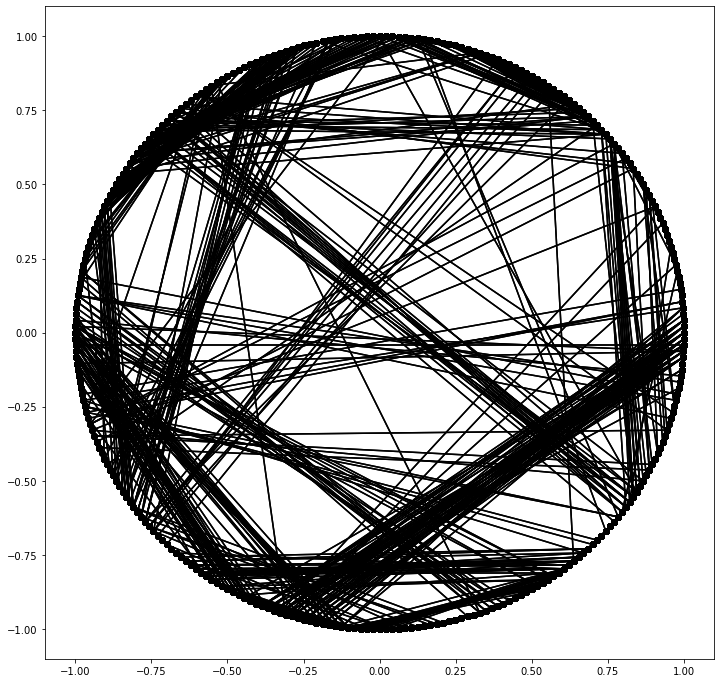

                                  target       sampled
Claw Count                  16800.000000  25228.000000
Characteristic Path Length     19.190635      4.379287
Square Count                 6600.000000   4181.000000
Wedge Count                  8400.000000   9590.000000
Edge Overlap (%)                1.000000      0.513333
Time (s)                             NaN      2.494754


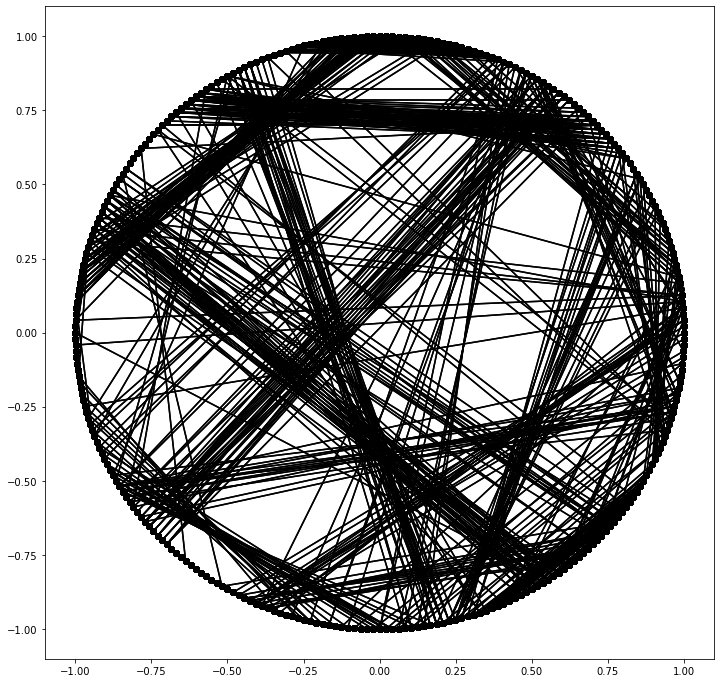

                                  target       sampled
Claw Count                  16800.000000  23849.000000
Characteristic Path Length     19.190635      4.322185
Square Count                 6600.000000   3796.000000
Wedge Count                  8400.000000   9392.000000
Edge Overlap (%)                1.000000      0.502500
Time (s)                             NaN      2.216465


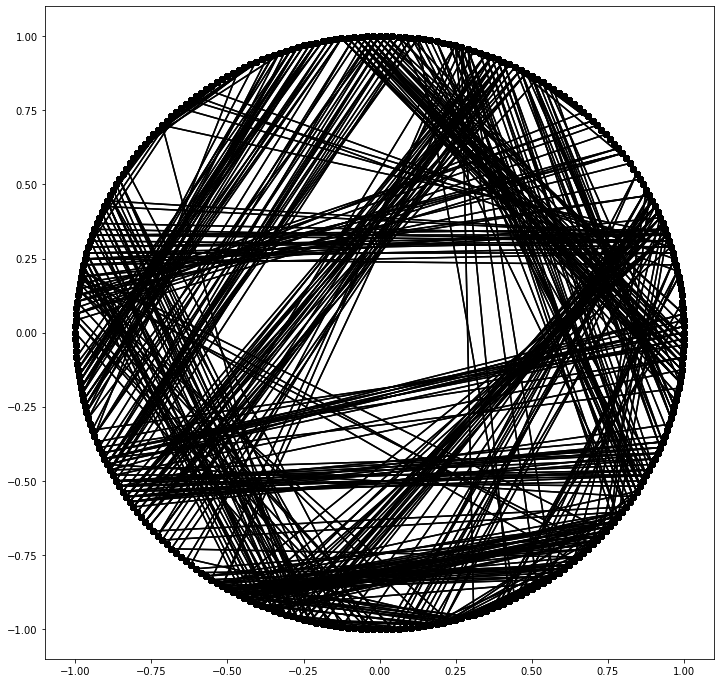

                                  target       sampled
Claw Count                  16800.000000  24217.000000
Characteristic Path Length     19.190635      4.348986
Square Count                 6600.000000   3562.000000
Wedge Count                  8400.000000   9425.000000
Edge Overlap (%)                1.000000      0.505000
Time (s)                             NaN      2.037043


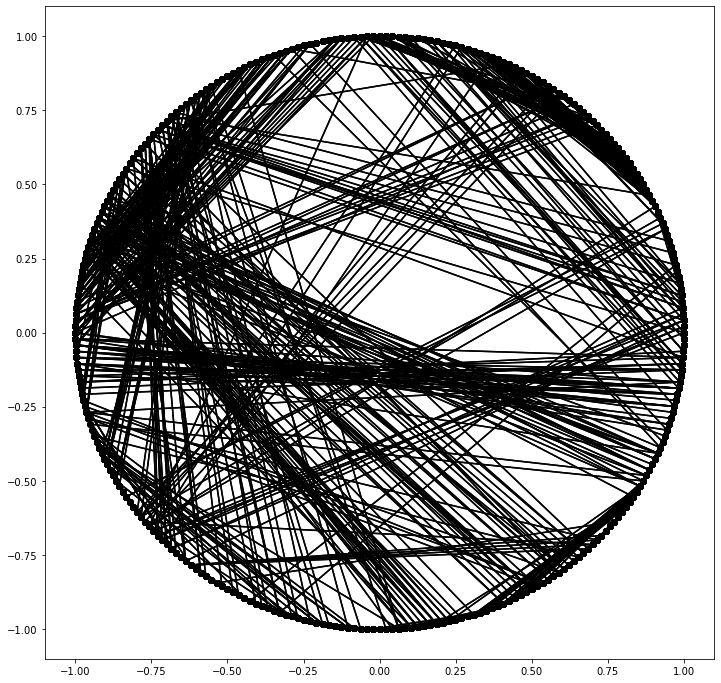

                                  target       sampled
Claw Count                  16800.000000  26353.000000
Characteristic Path Length     19.190635      4.294158
Square Count                 6600.000000   4382.000000
Wedge Count                  8400.000000   9741.000000
Edge Overlap (%)                1.000000      0.514167
Time (s)                             NaN      2.073442


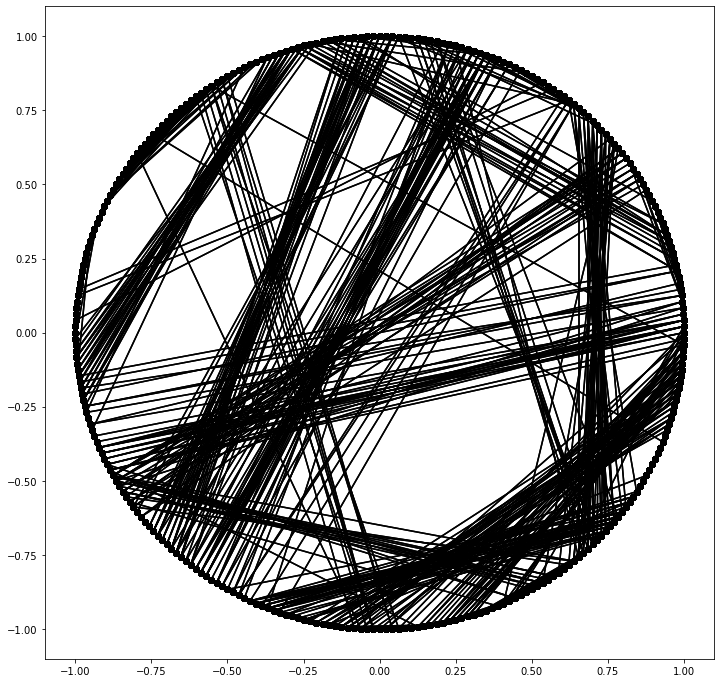

                                  target      sampled
Claw Count                  16800.000000  23646.00000
Characteristic Path Length     19.190635      4.55476
Square Count                 6600.000000   3909.00000
Wedge Count                  8400.000000   9335.00000
Edge Overlap (%)                1.000000      0.53500
Time (s)                             NaN      2.02141


In [20]:
for generated_graph, statistic in zip(generated_graphs_plain, statistics_plain):
    utils.plot_graph(generated_graph, xs)
    print(pd.DataFrame({"target": target_stats, "sampled": statistic}))

## Corrected Setting

In [8]:
eval_ours = Evaluation(experiment_root='../logs/cycle/Ours_corrected/',
                       statistic_fns=statistic_fns)

In [9]:
eval_ours.compute_statistics()

In [10]:
generated_graphs_corrected = [eval_ours.load_graph(experiment=i, step=100) for i in range(5)]
statistics_corrected = [eval_ours.get_tabular(experiment=i, step=100) for i in range(5)]

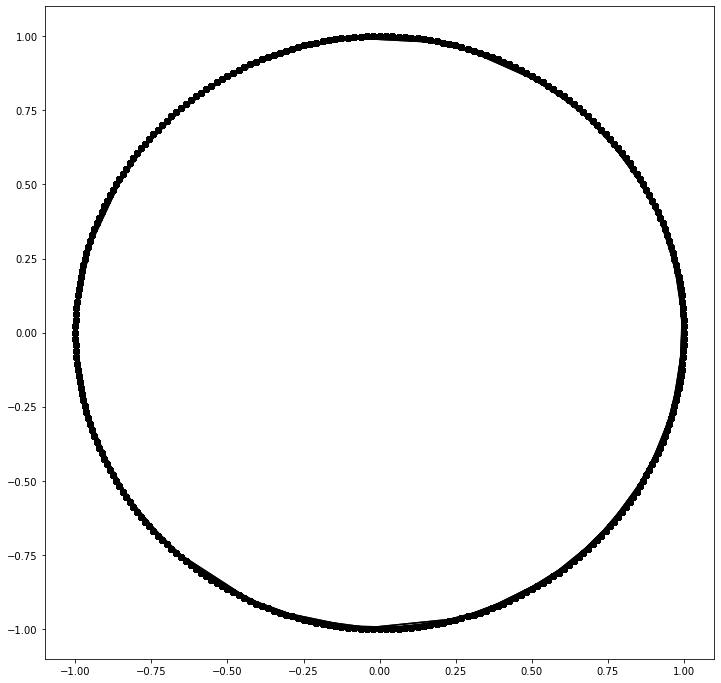

                                  target       sampled
Claw Count                  16800.000000  21843.000000
Characteristic Path Length     19.190635      8.254604
Square Count                 6600.000000   3975.000000
Wedge Count                  8400.000000   9100.000000
Edge Overlap (%)                1.000000      0.550833
Time (s)                             NaN      4.088138


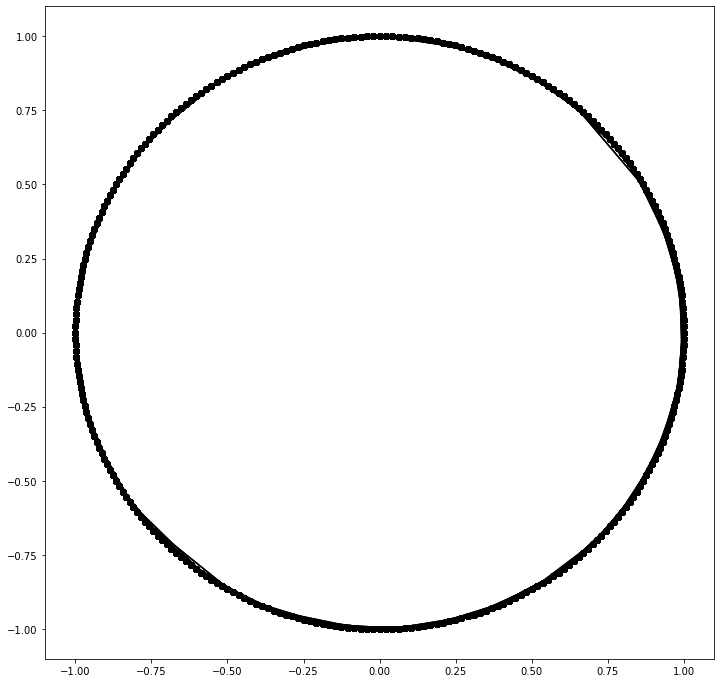

                                  target       sampled
Claw Count                  16800.000000  21495.000000
Characteristic Path Length     19.190635      8.113846
Square Count                 6600.000000   3900.000000
Wedge Count                  8400.000000   9066.000000
Edge Overlap (%)                1.000000      0.555000
Time (s)                             NaN      4.099620


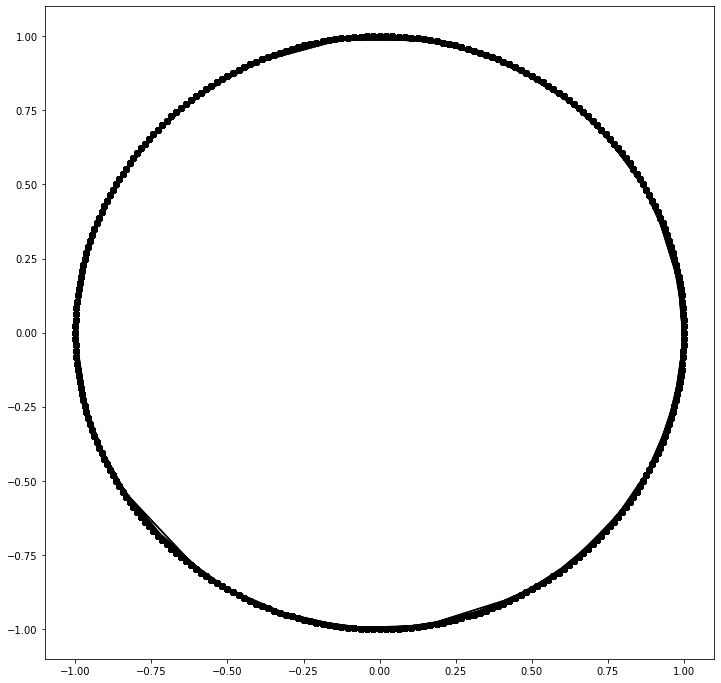

                                  target       sampled
Claw Count                  16800.000000  21014.000000
Characteristic Path Length     19.190635      8.401828
Square Count                 6600.000000   3821.000000
Wedge Count                  8400.000000   8991.000000
Edge Overlap (%)                1.000000      0.542500
Time (s)                             NaN      4.073246


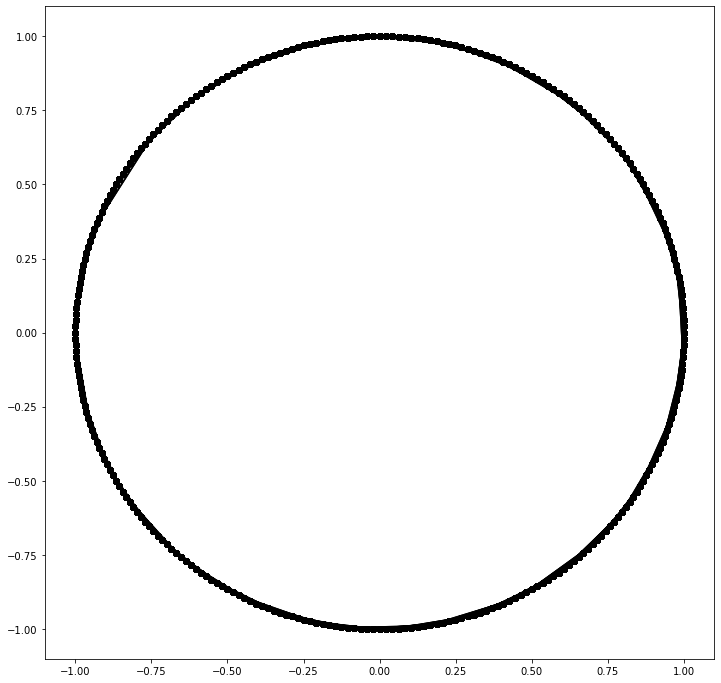

                                  target       sampled
Claw Count                  16800.000000  21689.000000
Characteristic Path Length     19.190635      8.456923
Square Count                 6600.000000   4017.000000
Wedge Count                  8400.000000   9091.000000
Edge Overlap (%)                1.000000      0.540000
Time (s)                             NaN      4.082806


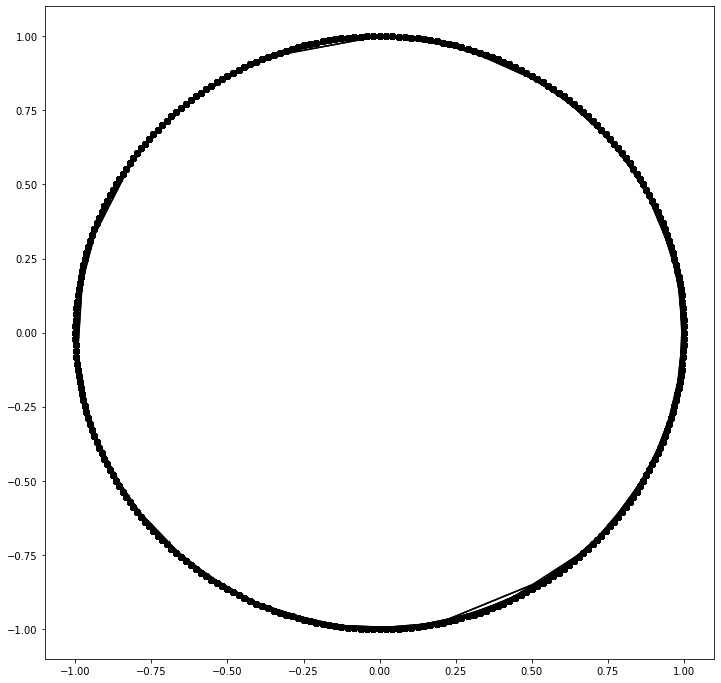

                                  target       sampled
Claw Count                  16800.000000  21784.000000
Characteristic Path Length     19.190635      8.158350
Square Count                 6600.000000   4003.000000
Wedge Count                  8400.000000   9103.000000
Edge Overlap (%)                1.000000      0.529167
Time (s)                             NaN      4.085801


In [12]:
for generated_graph, statistic in zip(generated_graphs_corrected, statistics_corrected):
    utils.plot_graph(generated_graph, xs)
    print(pd.DataFrame({"target": target_stats, "sampled": statistic}))

## Comparison

In [23]:
for statistic_corrected, statistic_plain in zip(statistics_corrected, statistics_plain):
    print('\n',pd.DataFrame({"target": target_stats,
                             "sampled_corrected": statistic_corrected,
                             "sampled_plain": statistic_plain}))


                                   target  sampled_corrected  sampled_plain
Claw Count                  16800.000000       21843.000000   25228.000000
Characteristic Path Length     19.190635           8.254604       4.379287
Square Count                 6600.000000        3975.000000    4181.000000
Wedge Count                  8400.000000        9100.000000    9590.000000
Edge Overlap (%)                1.000000           0.550833       0.513333
Time (s)                             NaN           4.088138       2.494754

                                   target  sampled_corrected  sampled_plain
Claw Count                  16800.000000       21495.000000   23849.000000
Characteristic Path Length     19.190635           8.113846       4.322185
Square Count                 6600.000000        3900.000000    3796.000000
Wedge Count                  8400.000000        9066.000000    9392.000000
Edge Overlap (%)                1.000000           0.555000       0.502500
Time (s)             